Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
import sklearn.preprocessing as Preprocessing
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline

### Visual inspection

I opened the text file in Excel and noticed that the values for the first three predictors are equal.

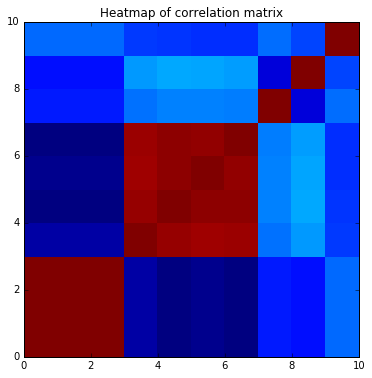

In [4]:
#load data
data=np.loadtxt('./datasets/dataset_1.txt',delimiter=',',skiprows=1)

#split predictors and response
x=data[:,:-1]
y=data[:,-1]

#compute matrix of correlation coefficients
corr_matrix=np.corrcoef(x.T)
corr_matrix.shape

fig,ax = plt.subplots(1, 1, figsize=(6, 6))

ax.pcolor(corr_matrix)

ax.set_title('Heatmap of correlation matrix')

plt.show()

### Do the predictors fall naturally into groups based on the correlation values?

There seems to be five groups.

### How many predictors will you pick? 

Five.

### Which ones will you choose?

I would pick one from each group.


In [26]:
# Exhaustive search
best_subset = [] 
# predictor_set=set(range(10))
predictor_set = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
min_bic = 1e10 # set some initial large value for min BIC score
#outer loop
for k in range(10):
    # subsets for size k
    subsets_k =it.combinations(predictor_set,k+1)
    #inner loop to compare BIC within subsets
    for subset in subsets_k:
        x_subset = x[:, subset]
        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        #compute BIC
        bic = results.bic
#         print r_squared,bic,subset[:]
        # keep track of best one
        # Update max R^2 and best predictor subset of size k
        # If current predictor subset has a higher R^2 score than that of the best subset 
        # we've found so far, remember the current predictor subset as the best!
        if(bic < min_bic): 
            min_bic = bic
            best_subset = subset[:]
    
print('Best subset by exhaustive search:')
print sorted(best_subset)

Best subset by exhaustive search:
[0, 5, 7, 8, 9]


In [27]:
### Step-wise Forward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors, and the remaining set of predictors
current_predictors = [] 
remaining_predictors = range(d)

# Set some initial large value for min BIC score for all possible subsets
global_min_bic = 1e10 

# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, 0 predictors to d predictors
for size in range(d):    
    max_r_squared = -1e10 # set some initial small value for max R^2
    best_predictor = -1 # set some throwaway initial number for the best predictor to add
    bic_with_best_predictor = 1e10 # set some initial large value for BIC score   
        
    # Iterate over all remaining predictors to find best predictor to add
    for i in remaining_predictors:
        # Make copy of current set of predictors
        temp = current_predictors[:]
        # Add predictor 'i'
        temp.append(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        
        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            best_predictor = i
            bic_with_best_predictor = results.bic
    
    # Remove best predictor from remaining list, and add best predictor to current list
    remaining_predictors.remove(best_predictor)
    current_predictors.append(best_predictor)
    
    # Check if BIC for with the predictor we just added is lower than 
    # the global minimum across all subset of predictors
    if(bic_with_best_predictor < global_min_bic):
        best_subset = current_predictors[:]
        global_min_bic = bic_with_best_predictor
    
print 'Step-wise forward subset selection:'
print sorted(best_subset) # add 1 as indices start from 0

Step-wise forward subset selection:
[0, 5, 7, 8, 9]


#### The predictors match the ones I selected 

In [32]:
#Apply Lasso regression with regularization parameter  λ=0.01 and fit a regression model.
reg = Lasso_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Lasso:'
print 'Coefficients:', coefficients
print  'Predictors that are assigned non-zero coefficients are:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Lasso:
Coefficients: [ 0.02717417  0.          0.         -0.         -0.02532806 -0.         -0.
  0.04397321 -0.40612185 -0.22260474]
Predictors that are assigned non-zero coefficients are: [0, 4, 7, 8, 9]


Yes, they correspond.

In [31]:
#Apply Ridge regression with regularization parameter  λ=0.01 and fit a regression model.
reg = Ridge_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Ridge:'
print 'Coefficients:', coefficients
print  'Predictors that are assigned non-zero coefficients are:', [i for i, item in enumerate(coefficients) if abs(item) > 0]


Ridge:
Coefficients: [ 0.04353543  0.04353543  0.04353543  0.55217415 -0.19706852 -0.61421737
  0.30484213  0.18742866 -0.50083242 -0.35908145]
Predictors that are assigned non-zero coefficients are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [67]:
# data2=np.loadtxt('./datasets/dataset_2.txt',delimiter=',',skiprows=1,index=1)
data2 = pd.read_csv('./datasets/dataset_2.txt', sep=',')
# Need to make symboling column datatype equal object
data2['symboling']=data2['symboling'].astype(object)
data2.head()

,horsepower,highway-mpg,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,...,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,peak-rpm,city-mpg,price
0,95.0,24.0,0,120.232558,peugot,gas,std,four,wagon,rwd,...,l,four,120.0,mpfi,3.46,2.19,8.4,5000.0,19.0,16695.0
1,116.0,30.0,2,134.000000,toyota,gas,std,two,hardtop,rwd,...,ohc,four,146.0,mpfi,3.62,3.50,9.3,4800.0,24.0,11199.0
2,121.0,28.0,0,188.000000,bmw,gas,std,two,sedan,rwd,...,ohc,six,164.0,mpfi,3.31,3.19,9.0,4250.0,21.0,20970.0
3,184.0,16.0,0,120.232558,mercedes-benz,gas,std,four,sedan,rwd,...,ohcv,eight,308.0,mpfi,3.80,3.35,8.0,4500.0,14.0,40960.0
4,111.0,29.0,0,102.000000,subaru,gas,turbo,four,sedan,4wd,...,ohcf,four,108.0,mpfi,3.62,2.64,7.7,4800.0,24.0,11259.0


In [68]:
# Separate predictors and response
x_df = data2.iloc[:,:-1]
y_df = data2.iloc[:,-1]

d = np.shape(x_df)[1] # no. of attributes

# Create a new data frame

x_df_expanded = pd.DataFrame() 

# Iterate over all attributes
for column in x_df.columns:
    # Check if attribute is not categorical: either dtype is not object
    if(x_df[column].dtype != np.dtype('object')):
        x_df_expanded = pd.concat([x_df_expanded, x_df[column]], axis=1)
    else:
        # otherwise: use one-hot encoding
        encoding = pd.get_dummies(x_df[column])  # Convert categorical variable into dummy/indicator variables
        # append expanded attribute to data frame
        x_df_expanded = pd.concat([x_df_expanded, encoding], axis=1)
        print encoding.iloc[:1].values
x_df_expanded.head()

[[ 0.  1.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0.]]
[[ 0.  1.]]
[[ 1.  0.]]
[[ 1.  0.]]
[[ 0.  0.  0.  0.  1.]]
[[ 0.  0.  1.]]
[[ 1.  0.]]
[[ 0.  1.  0.  0.  0.]]
[[ 0.  0.  1.  0.]]
[[ 0.  0.  0.  1.  0.]]


,horsepower,highway-mpg,-2.0,0.0,1.0,1.09604519774,2.0,3.0,normalized-losses,audi,...,1bbl,2bbl,idi,mpfi,spdi,bore,stroke,compression-ratio,peak-rpm,city-mpg
0,95.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,120.232558,0.0,...,0.0,0.0,0.0,1.0,0.0,3.46,2.19,8.4,5000.0,19.0
1,116.0,30.0,0.0,0.0,0.0,0.0,1.0,0.0,134.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,3.62,3.50,9.3,4800.0,24.0
2,121.0,28.0,0.0,1.0,0.0,0.0,0.0,0.0,188.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,3.31,3.19,9.0,4250.0,21.0
3,184.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,120.232558,0.0,...,0.0,0.0,0.0,1.0,0.0,3.80,3.35,8.0,4500.0,14.0
4,111.0,29.0,0.0,1.0,0.0,0.0,0.0,0.0,102.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,3.62,2.64,7.7,4800.0,24.0


In [49]:
# Convert data frame to array
x = x_df_expanded.values
y = y_df.values

# ii. SPLIT TRAIN AND TEST SETS
# No. of training points
n = x.shape[0]
n_train = int(np.round(n*0.25))

# First 25% train, remaining test
x_train = x[0:n_train,:]
y_train = y[0:n_train]
x_test = x[n_train:,:]
y_test = y[n_train:]

In [75]:
# Fit sklearn multiple linear regression model
reg = Lin_Reg()
reg.fit(x_train, y_train)
    
# Get coefficients from fitted model
w = reg.coef_
c = reg.intercept_

# print w,c

regscore=reg.score(x_train, y_train)
regtestscore=reg.score(x_test, y_test)
print "Train score    | Test score"
print regscore,"|",regtestscore

Train score    | Test score
0.999511805235 | 0.841119316862


Those scores look pretty good.
I don't see any discrepancies.
Regularization is not needed.

### Part (c): Apply Ridge regression

- Apply Ridge regression on the training set for different values of the regularization parameter $\lambda$ in the range $\{10^{-7}, 10^{-6}, \ldots, 10^7\}$. Evaluate the R^2 score for the models you obtain on both the train and test sets. Plot both values as a function of $\lambda$. 


- Explain the relationship between the regularization parameter and the training and test R^2 scores.


- How does the best test R^2 value obtained using Ridge regression compare with that of plain linear regression? Explain.

**Note**: You may use the `statsmodels` or `sklearn` to fit a ridge regression model and evaluate the fits.

In [163]:
# degrees=7
# R2_train={}
# i=0
# Run for different values of lambda 
lambda_min = -7
lambda_max = 7

num_lambdas = 15
num_predictors = x.shape[1]

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)

coeff_a =np.zeros((num_lambdas, num_predictors))

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)
# for d in range(10**1/degrees, 10**degrees):
for ind, i in enumerate(lambdas):
    reg=Ridge_Reg(alpha = 10**i)
# #         model_results, _ =reg.fit(x_train, y_train)
    reg.fit(x_train, y_train)
#         R2_train[i] = reg.score(x_train,y_train) #rsquared

#     coeff_a[ind,:] = reg.score
#     Evaluate train & test performance
    train_r_squared[ind] = reg.score(x_train, y_train)
    test_r_squared[ind] = reg.score(x_test, y_test)   


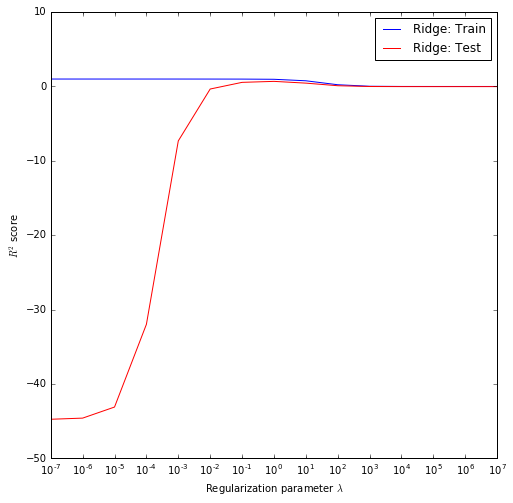

In [164]:
# Plot train an test R-squared as a function parameter value
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# ax.axhline(y = test_r_squared_plain, c='g', label = 'Plain Regression')
ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Ridge: Train')
ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Ridge: Test')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')

#ax.set_ylim((test_r_squared_plain-0.2, 1.2))
ax.legend(loc = 'best')
plt.show()

In [172]:
def ridge_regression_fit(x, y, alph):
    # Create the poly terms for x,x^2 .. 
    
    n= np.size(y)   # data size 
#     x_poly = np.zeros([n, degrees]) # poly degree 
    
    
#     for d in range(1, degrees +1):
#         x_poly[:, d - 1] = np.power(x, d).flatten()  # adding terms 

#     Xt=sm.add_constant(x_poly)
    model=Ridge_Reg(alpha=alph)
    model_results=model.fit(x,y)
    return model_results

In [173]:
## Now do cross validation k-fold
def AutoKfold(dt, K):
    step = N/K 
    nsim = 9
    degrees= 10

    plt.figure(figsize=(12,8))

    MSE_train = np.zeros([ degrees+1,K])
    MSE_test = np.zeros([ degrees+1,K])
    MSE_K = np.zeros([ degrees+1,nsim])

    for j in np.arange(0,nsim):
        dt=np.random.permutation(dt)[0:N]

        for i in np.arange(0,K):
            data_train = np.concatenate( (dt[:i*step] , dt[(i+1)*step:-1]))
            data_test = dt[i*step:(i+1)*step]


            X_train = data_train[:, 0:-1]
            Y_train = data_train[:, -1]

            X_test = data_test[:, 0:-1]
            Y_test = data_test[:,-1]

            for d in range(1, degrees +1):
                model_results = ridge_regression_fit(X_train,Y_train, d)
#                 yp=polynomial_regression_predict(model_results.params, d, X_train)
#                 RSS_train=np.sum((Y_train-yp)**2)
#                 MSE_train[d,i]=RSS_train/(N/2-degrees)

#                 y_hat=polynomial_regression_predict(model_results.params, d, X_test)
#                 RSS_test = np.sum((Y_test-y_hat)**2)
#                 TSS_test = np.sum((Y_test-np.mean(Y_test))**2)
#                 MSE_test[d,i]=RSS_test/(N/2-degrees)
                


        for d in range(1, degrees +1):
            MSE_K[d,j] = MSE_test[d,i].mean()

        plt.title('Auto Data k-Fold'); plt.xlabel('Polynomial degree'); plt.ylabel('MSE')
        plt.plot(MSE_K[1:, j])

In [174]:
N=data2.shape[0] 
AutoKfold(data2, 5)

ValueError: invalid literal for float(): 2bbl

By adding an identity matrix, the shrinkage penalty becomes close to zero. 
That has the effect of shrinking the estimates towards zero. 
When λ = 0, the penalty term has no effect, and ridge regression
will produce the least squares estimates. 

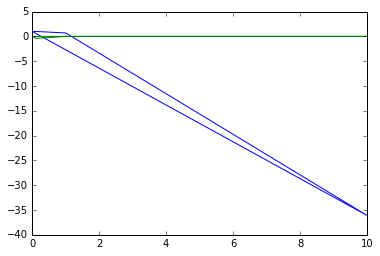

In [91]:
# Fit
def ridge(x_train, y_train, reg_param):
    n=np.shape(x_train)[0]
    x_train=np.concatenate((x_train,reg_param*np.identity(n)),axis=1)
    y_train_=np.zeros((n+np.shape(x_train)[1],1))
    for c in range(n):
        y_train_[c]= y_train[c]
    import sklearn
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_train,y_train.reshape(-1,1))
    return model

# Score
def score(m,x_test,y_test, reg_param):
    n=np.shape(x_train)[0]
    x_test=np.concatenate((x_test,reg_param*np.identity(n)),axis=1)
    y_test_=np.zeros((n+np.shape(x_test)[1],1))
    for c in range(n):
        y_test_[c]= y_test[c]
    return m.score(x_test,y_test.reshape(-1,1))

# Load
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')
n = data.shape[0]
n = int(np.round(n*0.5))
x_train = data[0:n,0:100]
y_train = data[0:n,100]
x_test = data[n:2*n,0:100]
y_test = data[n:2*n,100]

# Params
a=np.zeros(5)
for i in range(-2,2):
    a[i+2]=10**i

# Iterate
rstr =np.zeros(5)
rsts =np.zeros(5)
for j in range(0,5):    
    m =ridge(x_train,y_train,a[i])
    rstr[j]=score(m,x_train,y_train,a[j])
    rsts[i]=score(m,x_test,y_test,a[i])

# Plot
plt.plot(a,rstr)
plt.plot(a,rsts)

I'd give them a 3 assuming 1.3 points for each of the categories below:

correctness 1.3

interpretation (if applicable) .5

code/algorithm design .5

presentation .75


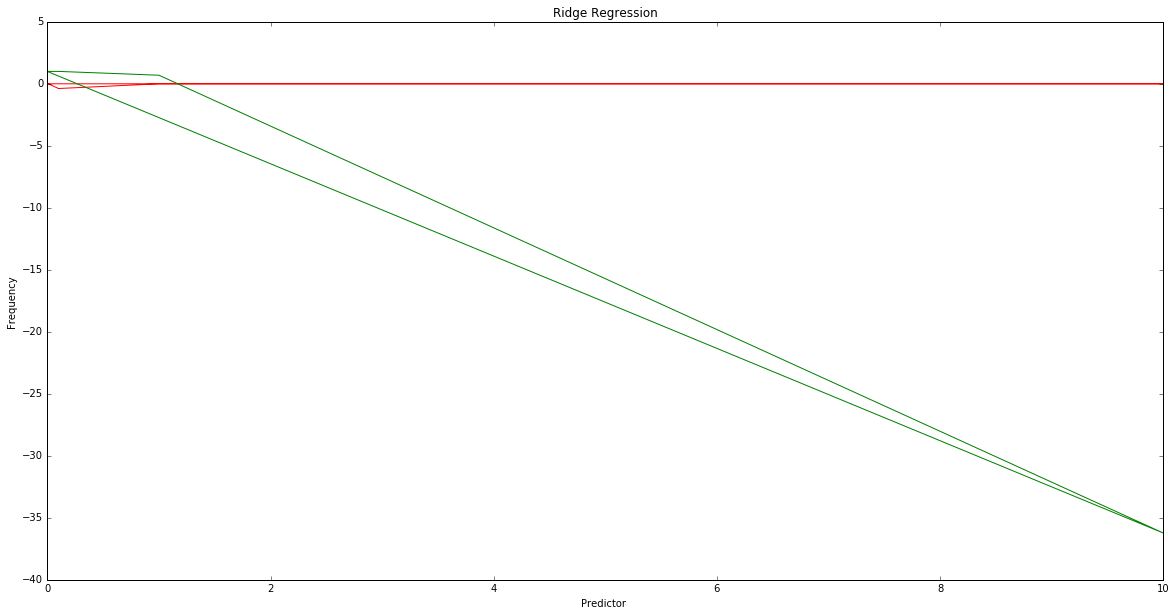

In [187]:
#refactored
#do the imports first
import sklearn

# Ridge fit function
# input: 
# x_train x training data
# y_train y training data
# reg_param regularization parameter
# output:
# model - is that really what we want to return
def ridge(x_train, y_train, reg_param):
    # get the length of the training data matrix first row
    n=x_train.shape[0]
    # add the identity matrix of the same size to our training data
    #is concatenate the best way to do it?
    x_train=np.concatenate((x_train,reg_param*np.identity(n)),axis=1)
    #add the same number of zeros to the training data
    y_train_=np.zeros((n+x_train.shape[1],1))
    #this loop is stupid, why couldn't I just concatenate as above instead of looping
    for c in range(n):
        y_train_[c]=y_train[c]
#     y_train=np.concatenate((y_train,np.identity(n)),axis=0)
    #defing the model
    model=sklearn.linear_model.LinearRegression()
#     Fit the model
    model.fit(x_train,y_train.T)
    #returning the model doesn't seem to be in the spirit of what we're trying to achieve here
    return model

# Score
def score(m,x_test,y_test, reg_param):
    # get the length of the training data matrix first row
    #this seems like deja vu, why am I doing this again instead of scoring in my ridge function above
    n=x_train.shape[0]
    # add the identity matrix of the same size to our training data
    #is concatenate the best way to do it?
    x_test=np.concatenate((x_test,reg_param*np.identity(n)),axis=1)
    y_test_=np.zeros((n+x_test.shape[1],1))
    #this loop is also stupid, why couldn't I just concatenate as above instead of looping
    for c in range(n):
        y_test_[c]=y_test[c]
    return m.score(x_test,y_test.T)

# Load
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')
# First 50% train, remaining test
n=data.shape[0]
n_train=int(n * 0.5)

#split the data into test and training sets
x_train=data[:n_train,:100]
y_train=data[:n_train,100]
x_test=data[n_train:,:100]
y_test=data[n_train:,100]

# Params
a=np.zeros(5)
# why not just return the two below resultsets from the ridge function
rstr=np.zeros(5)
rsts=np.zeros(5)
# I don't really like this loop, my refactoring didn't work though
# a=range(10**1/2,10**2)
for i in range(-2,2):
    a[i+2]=10**i
#     a[i+2]=np.power([10], i)

# I still think I can do the train and score in the same function
for j in range(0,5):    
    m =ridge(x_train,y_train,a[i])
    rstr[j]=score(m,x_train,y_train,a[j])
    rsts[i]=score(m,x_test,y_test,a[i])

# Plot of scores
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
# Set plot labels
axes.set_title('Ridge Regression')
axes.set_xlabel('Predictor ')
axes.set_ylabel('Frequency')
# plot the resultsets
plt.plot(a,rsts,c='r')
plt.plot(a,rstr,c='g')